In [14]:
import os
import numpy as np
import re
import string
from timeit import default_timer as timer
from pathlib import Path
import pandas as pd
import numpy as np
import statistics

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.metrics import hamming_loss

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print("Cpu cores found:", os.cpu_count())

Cpu cores found: 24


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_y = pd.read_csv("data/test_labels.csv")
sample_sub_df = pd.read_csv("data/sample_submission.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
train.shape, test.shape

((159571, 8), (153164, 2))

In [8]:
train_labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

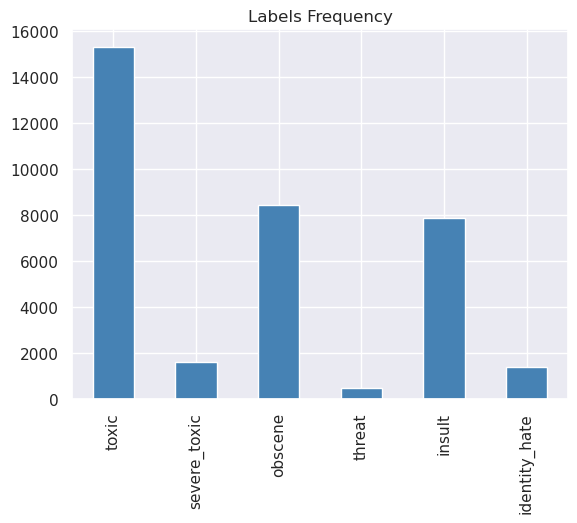

In [9]:
sns.set(color_codes=True)
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')
plt.show()

In [10]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
def tokenize(text):
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ever/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=True, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [16]:
vector.get_feature_names_out()[:10]

array(['aaa', 'aap', 'aardvark', 'aaron', 'aba', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abbas'], dtype=object)

In [17]:
clf = LogisticRegression()

In [18]:
def cross_validation_score(classifier, X_train, y_train):
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [19]:
methods_cv = pd.DataFrame(cross_validation_score(clf, X_train, train))
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
cv = methods_cv.reset_index()
cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,LogisticRegression,toxic,0.616516,0.734597
1,LogisticRegression,severe_toxic,0.255181,0.351982
2,LogisticRegression,obscene,0.638540,0.747416
3,LogisticRegression,threat,0.131605,0.218787
4,LogisticRegression,insult,0.524943,0.637112
5,LogisticRegression,identity_hate,0.203592,0.312104


In [20]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods
h, method = score(clf, X_train, train, X_test, test_y)

In [21]:
method = pd.DataFrame(method)
method.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
evaluate = method.reset_index()
evaluate[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,LogisticRegression,toxic,0.935603,0.936960
1,LogisticRegression,severe_toxic,0.993107,0.992796
2,LogisticRegression,obscene,0.965754,0.964088
3,LogisticRegression,threat,0.996374,0.995736
4,LogisticRegression,insult,0.964441,0.961573
5,LogisticRegression,identity_hate,0.990372,0.988347


In [22]:
# hyper-parameter tuning
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'class_weight': None, 'solver': 'lbfgs'}


LogisticRegression()

In [23]:
grid_search.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
train_df, val_df = train_test_split(train, test_size=0.3, random_state=43)
train_df.shape, val_df.shape

((111699, 8), (47872, 8))

In [26]:
x_train = vector.transform(train_df.comment_text)
x_val = vector.transform(val_df.comment_text)
y_train = train_df[test_labels].to_numpy()
y_val = val_df[test_labels].to_numpy()

In [27]:
%%time
base_est = LogisticRegression(solver='lbfgs', penalty='l2', 
                              max_iter=1000, random_state=42, 
                              n_jobs=-1, tol=1e-5)

cv = StratifiedKFold(n_splits=5, shuffle=True)
chain = ClassifierChain(base_estimator=base_est,
                        cv=cv, 
                        random_state=42, 
                        verbose=True).fit(x_train, y_train)

[Chain] ................... (1 of 6) Processing order 0, total=   2.4s
[Chain] ................... (2 of 6) Processing order 1, total=   1.1s
[Chain] ................... (3 of 6) Processing order 2, total=   1.7s
[Chain] ................... (4 of 6) Processing order 3, total=   1.0s
[Chain] ................... (5 of 6) Processing order 4, total=   2.1s
[Chain] ................... (6 of 6) Processing order 5, total=   1.8s
CPU times: user 4.86 s, sys: 990 ms, total: 5.85 s
Wall time: 36 s


In [28]:
train_pred = chain.predict(x_train)
val_pred = chain.predict(x_val)

print("Train ROC:", roc_auc_score(y_train,train_pred))
print("VAl ROC:", roc_auc_score(y_val,val_pred))
print("Train Acc:", accuracy_score(y_train, train_pred))
print("Val Acc:", accuracy_score(y_val, val_pred))

Train ROC: 0.7229049399930149
VAl ROC: 0.7027360317720501
Train Acc: 0.928235704885451
Val Acc: 0.9204545454545454


In [29]:
x_test = vector.transform(test.comment_text)
sample_sub_df.loc[:, test_labels] = chain.predict_proba(x_test)
sample_sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.990195,0.151399,0.983595,0.042271,0.883075,0.363824
1,0000247867823ef7,0.008332,0.000946,0.005850,0.000902,0.011997,0.002277
2,00013b17ad220c46,0.009841,0.000514,0.004436,0.000410,0.004853,0.000867
3,00017563c3f7919a,0.006241,0.000909,0.004021,0.000655,0.005824,0.001038
4,00017695ad8997eb,0.029513,0.000482,0.008132,0.000718,0.008477,0.001117
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.543203,0.020026,0.198382,0.007493,0.040279,0.012706
153160,fffd7a9a6eb32c16,0.086951,0.000882,0.020037,0.001858,0.028346,0.003275
153161,fffda9e8d6fafa9e,0.010819,0.000824,0.008613,0.000782,0.008891,0.001807
153162,fffe8f1340a79fc2,0.040204,0.001102,0.015856,0.000941,0.017645,0.008401
